# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import train and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [2]:
#Name
ModelName = 'titanic_propensity_survive'
#Version
ModelVersion = 'v1'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'survived'
VarId = 'passengerid'
VarDate = 'referencedate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Bucket already created on S3
bucket = 'data-science-lab'

CAT = [
'pclass'
,'embarked'
,'cabine_prefix'
,'ticket_str'
,'nametitle']

#float
NUM = [
'fare'
,'sibsp'
,'parch'
,'age_mean'
,'ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [3]:
import sys
sys.path.append('/var/lang/lib/python37.zip')
sys.path.append('/var/lang/lib/python3.7')
sys.path.append('/var/lang/lib/python3.7/lib-dynload')
sys.path.append('/var/lang/lib/python3.7/site-packages')
sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')

In [4]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [5]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [8]:
query4="select * from auladeploymodelos.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="auladeploymodelos", boto3_session=my_boto3_session)

In [9]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [10]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

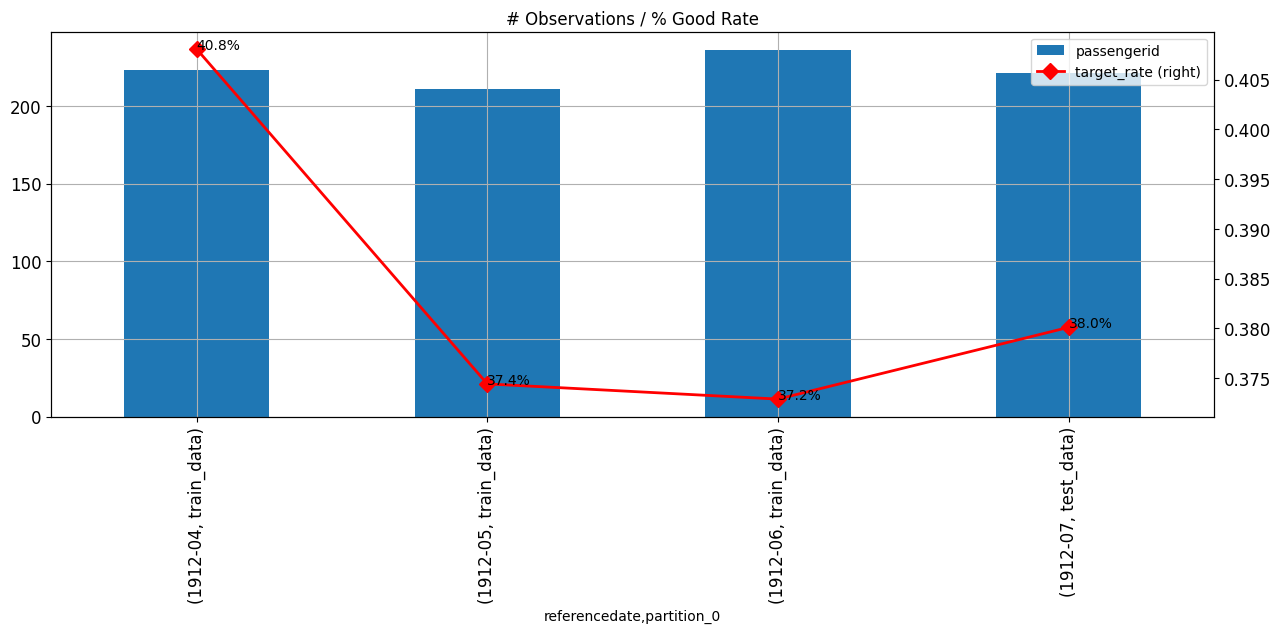

In [11]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [12]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [13]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [14]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [15]:
# region = my_boto3_session.region_name
# session = sagemaker.Session(my_boto3_session)

# # You can modify the following to use a bucket of your choosing
# prefix = "models/%s/sagemaker-temp" % ModelName

# role = get_execution_role()

# # # This is the client we will use to interact with SageMaker AutoPilot
# sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

# input_data_config = [
#     {
#         "DataSource": {
#             "S3DataSource": {
#                 "S3DataType": "S3Prefix",
#                 "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
#             }
#         },
#         "TargetAttributeName": 'Survived',
#     }
# ]

# output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [16]:
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

# auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
# print("AutoMLJobName: " + auto_ml_job_name)

# #Run SageMaker Autopilot
# sm.create_auto_ml_job(
#     AutoMLJobName=auto_ml_job_name,
#     InputDataConfig=input_data_config,
#     OutputDataConfig=output_data_config,
#     AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 3}},
#     RoleArn=role
# )

In [17]:
# print("JobStatus - Secondary Status")
# print("------------------------------")

# describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
# print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
# job_run_status = describe_response["AutoMLJobStatus"]

# while job_run_status not in ("Failed", "Completed", "Stopped"):
#     describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
#     job_run_status = describe_response["AutoMLJobStatus"]

#     print(
#         describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
#     )
#     sleep(30)

### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [18]:
# #Select best candidate
# best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
# best_candidate_name = best_candidate["CandidateName"]

# #Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
# for i in range(len(best_candidate["InferenceContainers"])):
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
#     best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

# #Create endpoint configuration
# timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
# model_name = best_candidate_name + timestamp_suffix + "-model"
# model_arn = sm.create_model(
#     Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
# )

# epc_name = best_candidate_name + timestamp_suffix + "-epc"
# ep_config = sm.create_endpoint_config(
#     EndpointConfigName=epc_name,
#     ProductionVariants=[
#         {
#             "InstanceType": "ml.m5.2xlarge",
#             "InitialInstanceCount": 1,
#             "ModelName": model_name,
#             "VariantName": "main",
#         }
#     ],
# )

# #Create end endpoint
# ep_name = best_candidate_name + timestamp_suffix + "-ep"
# create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
# sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
# print("ep_name: " + str(ep_name))

In [19]:
# #Create Predictor
# sm_predictor = Predictor(
#     endpoint_name=ep_name,
#     sagemaker_session=session,
#     serializer=CSVSerializer(),
#     deserializer=CSVDeserializer(),
# )

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [20]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_342"; OpenJDK Runtime Environment Corretto-8.342.07.4 (build 1.8.0_342-b07); OpenJDK 64-Bit Server VM Corretto-8.342.07.4 (build 25.342-b07, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyad6smjr
  JVM stdout: /tmp/tmpyad6smjr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyad6smjr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/GMT
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.3
H2O_cluster_version_age:,2 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_brouho
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.549 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [21]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 606
Validation: 64


In [22]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 221


## 4.2.2 Train the H2O Champion algorithm with new data

In [23]:
# h2o_champion = h2o.load_model('StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002')
# h2o_champion

In [24]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:03.529684

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_titanic_propensity_survive_v1_20220926_221213


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,46.0,46.0,4724.0,1.0,4.0,2.391304,2.0,5.0,3.478261




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.13232521640738032
RMSE: 0.3637653315083508
LogLoss: 0.4276191766246271
Mean Per-Class Error: 0.1789475489691606
AUC: 0.8871851165769042
AUCPR: 0.8703138396331312
Gini: 0.7743702331538085

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45297853775574104: 


,,0,1,Error,Rate
0,0,307.0,62.0,0.168,(62.0/369.0)
1,1,45.0,192.0,0.1899,(45.0/237.0)
2,Total,352.0,254.0,0.1766,(107.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.452979,0.782077,196.0
1,max f2,0.231690,0.833333,269.0
2,max f0point5,0.575104,0.842044,130.0
3,max accuracy,0.575104,0.830033,130.0
4,max precision,0.884329,1.000000,0.0
5,max recall,0.107404,1.000000,382.0
6,max specificity,0.884329,1.000000,0.0
7,max absolute_mcc,0.575104,0.649598,130.0
8,max min_per_class_accuracy,0.452979,0.810127,196.0
9,max mean_per_class_accuracy,0.452979,0.821052,196.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 39.23 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.876839,2.556962,2.556962,1.000000,0.879147,1.000000,0.879147,0.029536,0.029536,155.696203,155.696203,0.029536
1,2,0.023102,0.870695,2.556962,2.556962,1.000000,0.872225,1.000000,0.875686,0.029536,0.059072,155.696203,155.696203,0.059072
2,3,0.031353,0.862939,2.556962,2.556962,1.000000,0.864483,1.000000,0.872738,0.021097,0.080169,155.696203,155.696203,0.080169
3,4,0.042904,0.857056,2.556962,2.556962,1.000000,0.859535,1.000000,0.869183,0.029536,0.109705,155.696203,155.696203,0.109705
4,5,0.051155,0.849836,2.556962,2.556962,1.000000,0.853247,1.000000,0.866613,0.021097,0.130802,155.696203,155.696203,0.130802
5,6,0.100660,0.809671,2.471730,2.515045,0.966667,0.829498,0.983607,0.848360,0.122363,0.253165,147.172996,151.504462,0.250455
6,7,0.150165,0.719194,2.471730,2.500765,0.966667,0.767243,0.978022,0.821618,0.122363,0.375527,147.172996,150.076506,0.370107
7,8,0.201320,0.678573,2.309514,2.452168,0.903226,0.699917,0.959016,0.790694,0.118143,0.493671,130.951409,145.216850,0.480121
8,9,0.301980,0.537829,1.718614,2.207650,0.672131,0.585055,0.863388,0.722148,0.172996,0.666667,71.861382,120.765027,0.598916
9,10,0.400990,0.458892,1.108017,1.936136,0.433333,0.491496,0.757202,0.665197,0.109705,0.776371,10.801688,93.613585,0.616480




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.13286589438064314
RMSE: 0.3645077425523951
LogLoss: 0.4322506204551996
Mean Per-Class Error: 0.15448504983388703
AUC: 0.8549280177187153
AUCPR: 0.8006545519549297
Gini: 0.7098560354374306

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5655004314881706: 


,,0,1,Error,Rate
0,0,42.0,1.0,0.0233,(1.0/43.0)
1,1,6.0,15.0,0.2857,(6.0/21.0)
2,Total,48.0,16.0,0.1094,(7.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.565500,0.810811,14.0
1,max f2,0.187841,0.787402,41.0
2,max f0point5,0.565500,0.882353,14.0
3,max accuracy,0.565500,0.890625,14.0
4,max precision,0.876231,1.000000,0.0
5,max recall,0.109647,1.000000,54.0
6,max specificity,0.876231,1.000000,0.0
7,max absolute_mcc,0.565500,0.749308,14.0
8,max min_per_class_accuracy,0.496688,0.761905,19.0
9,max mean_per_class_accuracy,0.565500,0.845515,14.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 38.02 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.875897,3.047619,3.047619,1.000000,0.876231,1.000000,0.876231,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.865948,3.047619,3.047619,1.000000,0.875700,1.000000,0.875966,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.842320,0.000000,3.047619,0.000000,0.000000,1.000000,0.875966,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.837780,3.047619,3.047619,1.000000,0.838194,1.000000,0.863375,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.078125,0.837398,1.523810,2.438095,0.500000,0.837398,0.800000,0.852984,0.047619,0.190476,52.380952,143.809524,0.167220
5,6,0.109375,0.816478,3.047619,2.612245,1.000000,0.822002,0.857143,0.844132,0.095238,0.285714,204.761905,161.224490,0.262458
6,7,0.156250,0.733405,3.047619,2.742857,1.000000,0.783246,0.900000,0.825866,0.142857,0.428571,204.761905,174.285714,0.405316
7,8,0.203125,0.682898,3.047619,2.813187,1.000000,0.696253,0.923077,0.795955,0.142857,0.571429,204.761905,181.318681,0.548173
8,9,0.296875,0.508101,1.523810,2.406015,0.500000,0.591323,0.789474,0.731335,0.142857,0.714286,52.380952,140.601504,0.621262
9,10,0.406250,0.409500,0.435374,1.875458,0.142857,0.463291,0.615385,0.659169,0.047619,0.761905,-56.462585,87.545788,0.529347




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.14696841987050635
RMSE: 0.3833646043527054
LogLoss: 0.46621474333425866
Mean Per-Class Error: 0.20709409625741826
AUC: 0.8586497890295359
AUCPR: 0.820253017350523
Gini: 0.7172995780590719

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.411276986263452: 


,,0,1,Error,Rate
0,0,280.0,89.0,0.2412,(89.0/369.0)
1,1,41.0,196.0,0.173,(41.0/237.0)
2,Total,321.0,285.0,0.2145,(130.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.411277,0.750958,214.0
1,max f2,0.304601,0.820312,251.0
2,max f0point5,0.565321,0.813288,129.0
3,max accuracy,0.565321,0.815182,129.0
4,max precision,0.895488,1.000000,0.0
5,max recall,0.075327,1.000000,394.0
6,max specificity,0.895488,1.000000,0.0
7,max absolute_mcc,0.565321,0.613518,129.0
8,max min_per_class_accuracy,0.425492,0.780591,202.0
9,max mean_per_class_accuracy,0.411277,0.792906,214.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 39.39 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.880973,2.191682,2.191682,0.857143,0.885734,0.857143,0.885734,0.025316,0.025316,119.168174,119.168174,0.022606
1,2,0.021452,0.867710,2.130802,2.163583,0.833333,0.874944,0.846154,0.880754,0.021097,0.046414,113.080169,116.358325,0.040993
2,3,0.031353,0.854798,2.130802,2.153231,0.833333,0.857472,0.842105,0.873402,0.021097,0.067511,113.080169,115.323118,0.059380
3,4,0.041254,0.835255,2.556962,2.250127,1.000000,0.844498,0.880000,0.866465,0.025316,0.092827,155.696203,125.012658,0.084697
4,5,0.051155,0.812767,2.556962,2.309514,1.000000,0.824023,0.903226,0.858250,0.025316,0.118143,155.696203,130.951409,0.110013
5,6,0.100660,0.751924,2.556962,2.431210,1.000000,0.783918,0.950820,0.821693,0.126582,0.244726,155.696203,143.120979,0.236596
6,7,0.150165,0.697415,2.471730,2.444568,0.966667,0.726364,0.956044,0.790266,0.122363,0.367089,147.172996,144.456809,0.356248
7,8,0.201320,0.629355,2.144549,2.368334,0.838710,0.658443,0.926230,0.756770,0.109705,0.476793,114.454880,136.833368,0.452403
8,9,0.300330,0.533019,1.534177,2.093337,0.600000,0.578315,0.818681,0.697939,0.151899,0.628692,53.417722,109.333704,0.539261
9,10,0.400990,0.460005,1.173687,1.862479,0.459016,0.493491,0.728395,0.646616,0.118143,0.746835,17.368749,86.247851,0.567974




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.806923,0.056262,0.811475,0.793388,0.727273,0.884298,0.818182
1,auc,0.861467,0.045810,0.877922,0.831281,0.818565,0.933188,0.846377
2,err,0.193077,0.056262,0.188525,0.206612,0.272727,0.115702,0.181818
3,err_count,23.400000,6.804411,23.000000,25.000000,33.000000,14.000000,22.000000
4,f0point5,0.751225,0.093724,0.734694,0.774193,0.612583,0.873786,0.760870
5,f1,0.768190,0.053446,0.757895,0.793388,0.691589,0.837209,0.760870
6,f2,0.790920,0.020336,0.782609,0.813559,0.793991,0.803571,0.760870
7,lift_top_group,2.587828,0.298486,2.711111,2.086207,2.880952,2.630435,2.630435
8,logloss,0.462268,0.051764,0.424920,0.524087,0.490635,0.395224,0.476476
9,max_per_class_error,0.249809,0.060681,0.200000,0.238095,0.354430,0.217391,0.239130



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-09-26 22:12:15,2.438 sec,0.0,0.487994,0.669233,0.500000,0.391089,1.000000,0.608911,0.473734,0.641356,0.500000,0.328125,1.000000,0.671875
1,,2022-09-26 22:12:16,2.459 sec,5.0,0.467256,0.627852,0.731290,0.653532,2.220520,0.339934,0.446987,0.589447,0.797896,0.626670,2.285714,0.218750
2,,2022-09-26 22:12:16,2.478 sec,10.0,0.426588,0.550744,0.831681,0.813398,2.556962,0.204620,0.408794,0.519605,0.853821,0.781713,3.047619,0.125000
3,,2022-09-26 22:12:16,2.498 sec,15.0,0.413021,0.524842,0.848610,0.828721,2.556962,0.212871,0.396092,0.495762,0.853821,0.795260,3.047619,0.125000
4,,2022-09-26 22:12:16,2.517 sec,20.0,0.393306,0.486876,0.869576,0.846853,2.556962,0.227723,0.382324,0.468471,0.856589,0.809012,3.047619,0.109375
5,,2022-09-26 22:12:16,2.539 sec,25.0,0.381208,0.463499,0.877346,0.855342,2.556962,0.214521,0.375702,0.454822,0.852713,0.807810,3.047619,0.109375
6,,2022-09-26 22:12:16,2.561 sec,30.0,0.379167,0.458808,0.878952,0.858777,2.556962,0.198020,0.372258,0.448646,0.851606,0.797787,3.047619,0.109375
7,,2022-09-26 22:12:16,2.585 sec,35.0,0.372927,0.446289,0.881754,0.862931,2.556962,0.189769,0.369393,0.442358,0.853821,0.798980,3.047619,0.109375
8,,2022-09-26 22:12:16,2.608 sec,40.0,0.369203,0.438956,0.884995,0.867202,2.556962,0.179868,0.368545,0.440784,0.853821,0.798572,3.047619,0.109375
9,,2022-09-26 22:12:16,2.632 sec,45.0,0.365040,0.430416,0.885779,0.868948,2.556962,0.178218,0.364773,0.432901,0.853821,0.799720,3.047619,0.109375



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,nametitle,201.414749,1.000000,0.601302
1,pclass,42.053246,0.208789,0.125545
2,ticket_int,31.617002,0.156975,0.094389
3,cabine_prefix,25.752705,0.127859,0.076882
4,fare,19.935818,0.098979,0.059516
5,embarked,5.669171,0.028147,0.016925
6,age_mean,4.922785,0.024441,0.014696
7,parch,1.344442,0.006675,0.004014
8,sibsp,1.301227,0.006460,0.003885
9,ticket_str,0.953422,0.004734,0.002846


## 4.2.3 Using H2O AutoML to performe all algorithms

In [25]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*2

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
22:12:18.291: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 0:02:02.349365



In [26]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_4_AutoML_1_20220926_221218,0.863528,0.879128,0.409414,0.178398,0.354317,0.12554
GBM_grid_1_AutoML_1_20220926_221218_model_13,0.85382,0.86605,0.426893,0.193387,0.362932,0.13172
StackedEnsemble_BestOfFamily_3_AutoML_1_20220926_221218,0.85368,0.870003,0.418171,0.18435,0.357981,0.128151
StackedEnsemble_AllModels_4_AutoML_1_20220926_221218,0.853331,0.871741,0.407863,0.179353,0.354055,0.125355
StackedEnsemble_AllModels_3_AutoML_1_20220926_221218,0.852807,0.871307,0.413317,0.179353,0.355743,0.126553
XGBoost_3_AutoML_1_20220926_221218,0.852389,0.864399,0.4295,0.18435,0.361514,0.130692
GBM_grid_1_AutoML_1_20220926_221218_model_8,0.852225,0.866267,0.431876,0.198384,0.366509,0.134329
XGBoost_grid_1_AutoML_1_20220926_221218_model_4,0.850869,0.863095,0.431267,0.183003,0.363149,0.131877
GBM_grid_1_AutoML_1_20220926_221218_model_1,0.85076,0.868657,0.434888,0.185306,0.368505,0.135796
GBM_grid_1_AutoML_1_20220926_221218_model_9,0.84778,0.866354,0.429445,0.175139,0.364334,0.132739


In [27]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_4_AutoML_1_20220926_221218

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.04566053589473269
RMSE: 0.21368326067975632
LogLoss: 0.1831660269245953
Null degrees of freedom: 605
Residual degrees of freedom: 600
Null deviance: 811.1101129160465
Residual deviance: 221.9972246326095
AIC: 233.9972246326095
AUC: 0.9899831909711503
AUCPR: 0.9866006975512622
Gini: 0.9799663819423006

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42948844166683037: 


,,0,1,Error,Rate
0,0,359.0,10.0,0.0271,(10.0/369.0)
1,1,18.0,219.0,0.0759,(18.0/237.0)
2,Total,377.0,229.0,0.0462,(28.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.429488,0.939914,179.0
1,max f2,0.312139,0.950207,203.0
2,max f0point5,0.647070,0.965418,151.0
3,max accuracy,0.429488,0.953795,179.0
4,max precision,0.987109,1.000000,0.0
5,max recall,0.134001,1.000000,269.0
6,max specificity,0.987109,1.000000,0.0
7,max absolute_mcc,0.429488,0.902750,179.0
8,max min_per_class_accuracy,0.367656,0.940928,189.0
9,max mean_per_class_accuracy,0.429488,0.948475,179.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 38.98 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.982440,2.556962,2.556962,1.000000,0.985076,1.000000,0.985076,0.029536,0.029536,155.696203,155.696203,0.029536
1,2,0.021452,0.977635,2.556962,2.556962,1.000000,0.979940,1.000000,0.982706,0.025316,0.054852,155.696203,155.696203,0.054852
2,3,0.031353,0.975037,2.556962,2.556962,1.000000,0.976282,1.000000,0.980677,0.025316,0.080169,155.696203,155.696203,0.080169
3,4,0.041254,0.972061,2.556962,2.556962,1.000000,0.973807,1.000000,0.979028,0.025316,0.105485,155.696203,155.696203,0.105485
4,5,0.051155,0.966641,2.556962,2.556962,1.000000,0.969677,1.000000,0.977219,0.025316,0.130802,155.696203,155.696203,0.130802
5,6,0.100660,0.943405,2.556962,2.556962,1.000000,0.956213,1.000000,0.966888,0.126582,0.257384,155.696203,155.696203,0.257384
6,7,0.150165,0.917210,2.556962,2.556962,1.000000,0.931936,1.000000,0.955365,0.126582,0.383966,155.696203,155.696203,0.383966
7,8,0.201320,0.876905,2.556962,2.556962,1.000000,0.899676,1.000000,0.941215,0.130802,0.514768,155.696203,155.696203,0.514768
8,9,0.300330,0.748670,2.556962,2.556962,1.000000,0.820829,1.000000,0.901527,0.253165,0.767932,155.696203,155.696203,0.767932
9,10,0.400990,0.360874,1.718614,2.346512,0.672131,0.568305,0.917695,0.817879,0.172996,0.940928,71.861382,134.651248,0.886728




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.10999581237903586
RMSE: 0.33165616589931785
LogLoss: 0.3755792206592439
Null degrees of freedom: 63
Residual degrees of freedom: 58
Null deviance: 82.09360090171138
Residual deviance: 48.07414024438321
AIC: 60.07414024438321
AUC: 0.868217054263566
AUCPR: 0.8501264675973196
Gini: 0.736434108527132

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6358003913733198: 


,,0,1,Error,Rate
0,0,41.0,2.0,0.0465,(2.0/43.0)
1,1,5.0,16.0,0.2381,(5.0/21.0)
2,Total,46.0,18.0,0.1094,(7.0/64.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.635800,0.820513,17.0
1,max f2,0.635800,0.784314,17.0
2,max f0point5,0.730689,0.882353,15.0
3,max accuracy,0.730689,0.890625,15.0
4,max precision,0.985205,1.000000,0.0
5,max recall,0.041624,1.000000,57.0
6,max specificity,0.985205,1.000000,0.0
7,max absolute_mcc,0.730689,0.749308,15.0
8,max min_per_class_accuracy,0.635800,0.761905,17.0
9,max mean_per_class_accuracy,0.635800,0.857697,17.0



Gains/Lift Table: Avg response rate: 32.81 %, avg score: 33.20 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.015625,0.982395,3.047619,3.047619,1.000000,0.985205,1.000000,0.985205,0.047619,0.047619,204.761905,204.761905,0.047619
1,2,0.031250,0.977830,3.047619,3.047619,1.000000,0.980744,1.000000,0.982974,0.047619,0.095238,204.761905,204.761905,0.095238
2,3,0.031250,0.970768,0.000000,3.047619,0.000000,0.000000,1.000000,0.982974,0.000000,0.095238,-100.000000,204.761905,0.095238
3,4,0.046875,0.967332,3.047619,3.047619,1.000000,0.969535,1.000000,0.978495,0.047619,0.142857,204.761905,204.761905,0.142857
4,5,0.062500,0.964978,3.047619,3.047619,1.000000,0.965299,1.000000,0.975196,0.047619,0.190476,204.761905,204.761905,0.190476
5,6,0.109375,0.928627,3.047619,3.047619,1.000000,0.942758,1.000000,0.961294,0.142857,0.333333,204.761905,204.761905,0.333333
6,7,0.156250,0.894518,3.047619,3.047619,1.000000,0.911982,1.000000,0.946500,0.142857,0.476190,204.761905,204.761905,0.476190
7,8,0.203125,0.776034,2.031746,2.813187,0.666667,0.830949,0.923077,0.919835,0.095238,0.571429,103.174603,181.318681,0.548173
8,9,0.296875,0.482927,2.031746,2.566416,0.666667,0.683792,0.842105,0.845295,0.190476,0.761905,103.174603,156.641604,0.692137
9,10,0.406250,0.211159,0.000000,1.875458,0.000000,0.300536,0.615385,0.698629,0.000000,0.761905,-100.000000,87.545788,0.529347




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.11510148697798156
RMSE: 0.3392661005434842
LogLoss: 0.3776383032985243
Null degrees of freedom: 605
Residual degrees of freedom: 600
Null deviance: 813.4429925375304
Residual deviance: 457.6976235978114
AIC: 469.6976235978114
AUC: 0.9027077401575704
AUCPR: 0.8640754946698394
Gini: 0.8054154803151408

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4187444279035984: 


,,0,1,Error,Rate
0,0,311.0,58.0,0.1572,(58.0/369.0)
1,1,39.0,198.0,0.1646,(39.0/237.0)
2,Total,350.0,256.0,0.1601,(97.0/606.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.418744,0.803245,193.0
1,max f2,0.180730,0.859498,256.0
2,max f0point5,0.658957,0.835979,129.0
3,max accuracy,0.578957,0.848185,148.0
4,max precision,0.994070,1.000000,0.0
5,max recall,0.024115,1.000000,384.0
6,max specificity,0.994070,1.000000,0.0
7,max absolute_mcc,0.507781,0.679236,167.0
8,max min_per_class_accuracy,0.418744,0.835443,193.0
9,max mean_per_class_accuracy,0.418744,0.839131,193.0



Gains/Lift Table: Avg response rate: 39.11 %, avg score: 39.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.011551,0.987365,2.191682,2.191682,0.857143,0.990528,0.857143,0.990528,0.025316,0.025316,119.168174,119.168174,0.022606
1,2,0.021452,0.983090,2.556962,2.360273,1.000000,0.984052,0.923077,0.987539,0.025316,0.050633,155.696203,136.027264,0.047923
2,3,0.031353,0.977474,2.556962,2.422385,1.000000,0.978700,0.947368,0.984748,0.025316,0.075949,155.696203,142.238508,0.073239
3,4,0.041254,0.975714,2.556962,2.454684,1.000000,0.976557,0.960000,0.982782,0.025316,0.101266,155.696203,145.468354,0.098556
4,5,0.051155,0.972516,2.556962,2.474479,1.000000,0.974247,0.967742,0.981130,0.025316,0.126582,155.696203,147.447938,0.123872
5,6,0.100660,0.938535,2.386498,2.431210,0.933333,0.953653,0.950820,0.967617,0.118143,0.244726,138.649789,143.120979,0.236596
6,7,0.150165,0.895768,2.301266,2.388371,0.900000,0.917688,0.934066,0.951157,0.113924,0.358650,130.126582,138.837112,0.342390
7,8,0.201320,0.823732,2.227031,2.347375,0.870968,0.857781,0.918033,0.927430,0.113924,0.472574,122.703144,134.737497,0.445474
8,9,0.300330,0.641008,2.045570,2.247879,0.800000,0.735836,0.879121,0.864267,0.202532,0.675105,104.556962,124.787870,0.615485
9,10,0.400990,0.483553,1.257522,1.999271,0.491803,0.553822,0.781893,0.786337,0.126582,0.801688,25.752231,99.927072,0.658056




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.854922,0.023071,0.878049,0.847328,0.843478,0.826446,0.879310
1,auc,0.903243,0.024089,0.944745,0.882184,0.894000,0.895775,0.899512
2,err,0.145078,0.023071,0.121951,0.152672,0.156522,0.173554,0.120690
3,err_count,17.600000,3.049590,15.000000,20.000000,18.000000,21.000000,14.000000
4,f0point5,0.816276,0.032972,0.852273,0.790816,0.813953,0.777778,0.846561
5,f1,0.811457,0.037118,0.857143,0.756098,0.823529,0.800000,0.820513
6,f2,0.807850,0.052335,0.862069,0.724299,0.833333,0.823529,0.796020
7,lift_top_group,2.348385,0.719078,2.365385,2.977273,1.150000,2.420000,2.829268
8,logloss,0.376966,0.043140,0.304400,0.396196,0.408018,0.405373,0.370845
9,max_per_class_error,0.198536,0.062535,0.134615,0.295455,0.160000,0.183099,0.219512



See the whole table with table.as_data_frame()



## 4.3 Compare performance on the TEST dataset for all trained models

In [28]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [29]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/var/lang/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'ticket_str' has levels not trained on: ["SCAH"]
  warnings.warn(w)
/var/lang/lib/python3.7/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'nametitle' has levels not trained on: ["Countess", "Ms"]
  warnings.warn(w)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


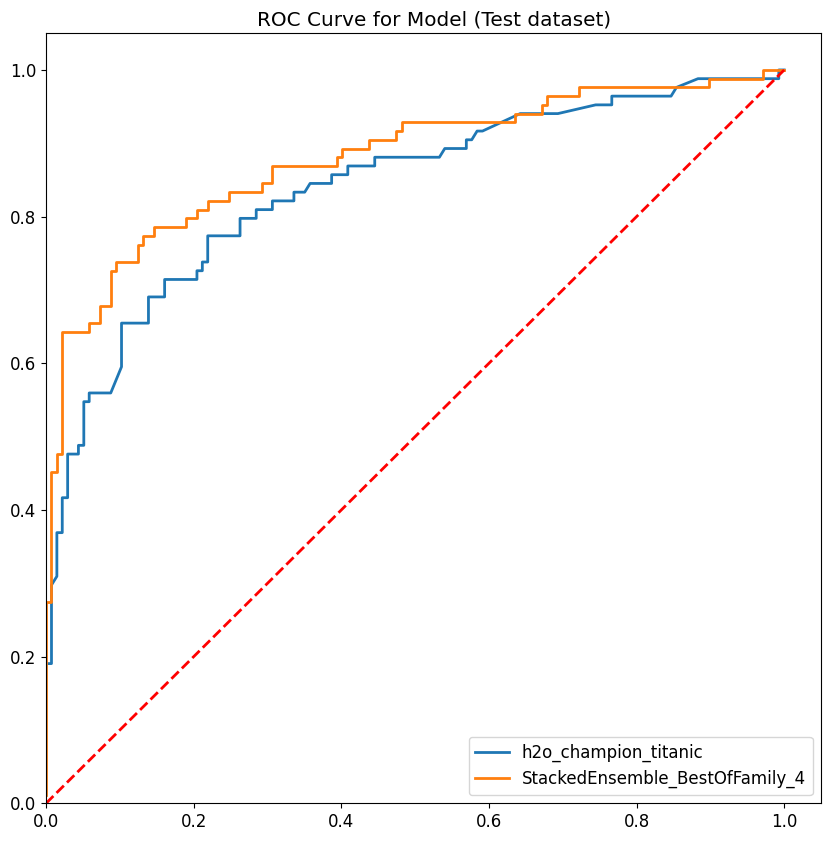

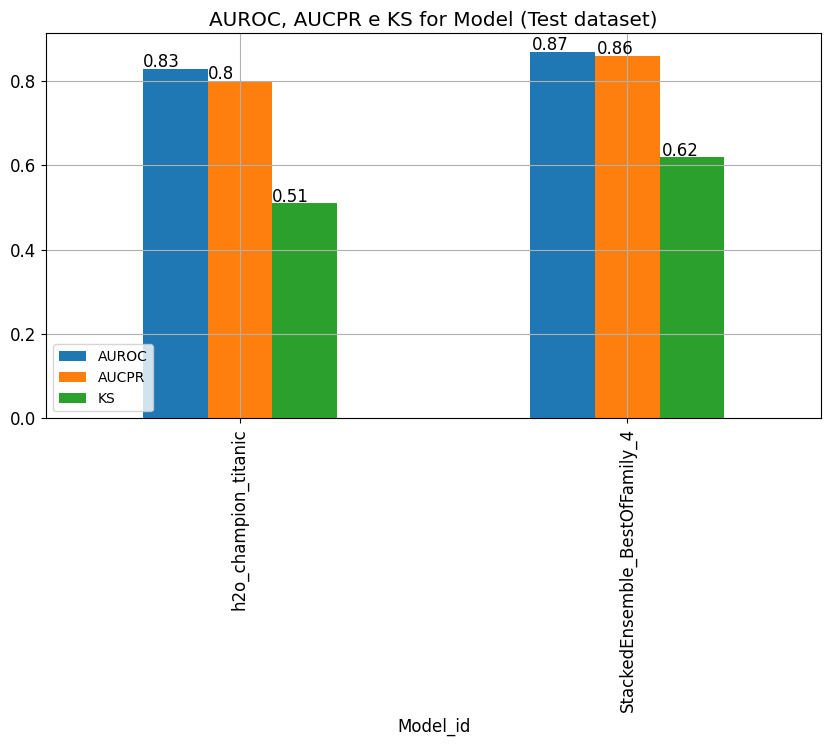

In [30]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [31]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,GBM_3_AutoML_1_20220917_194024,0.654049,0.902214,0.897827,0.366738,0.676,0.497483
1,0,StackedEnsemble_BestOfFamily_4_AutoML_1_20220926_221218,0.627948,0.879128,0.863528,0.409414,0.625,0.440586
2,0,h2o_champion_titanic_propensity_survive_v18_20220917_193952,0.550180,0.858238,0.857752,0.456765,0.626,0.550180
3,0,h2o_champion_titanic_propensity_survive_v1_20220926_221213,0.483557,0.839155,0.806852,0.483301,0.517,0.383971



BEST MODEL: GBM_3_AutoML_1_20220917_194024



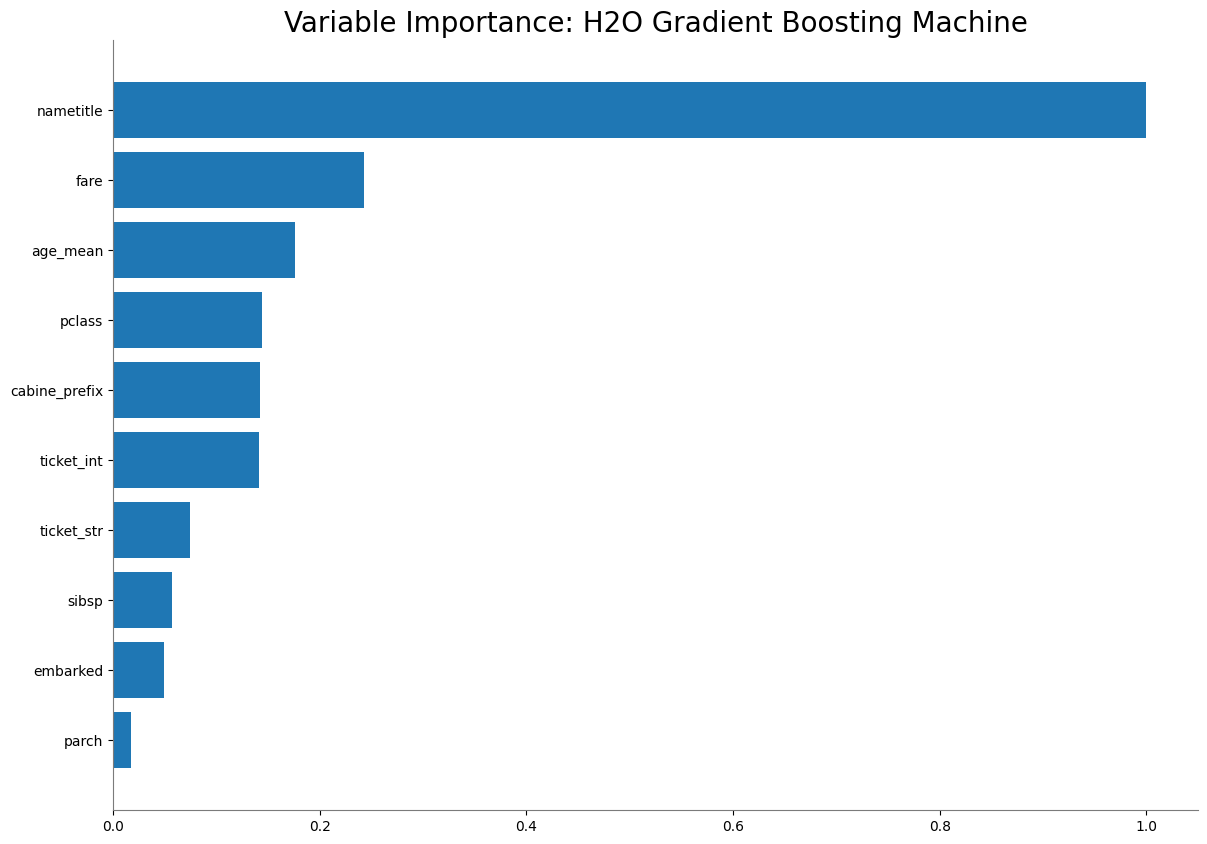

<Figure size 640x480 with 0 Axes>

In [32]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=0

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
    melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)
    melhor_modelo = modelos_testados.iloc[posicao_melhor_modelo, 0]
    (print("\n"+ "BEST MODEL: " + str(melhor_modelo) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [33]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True).to_list()
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [34]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


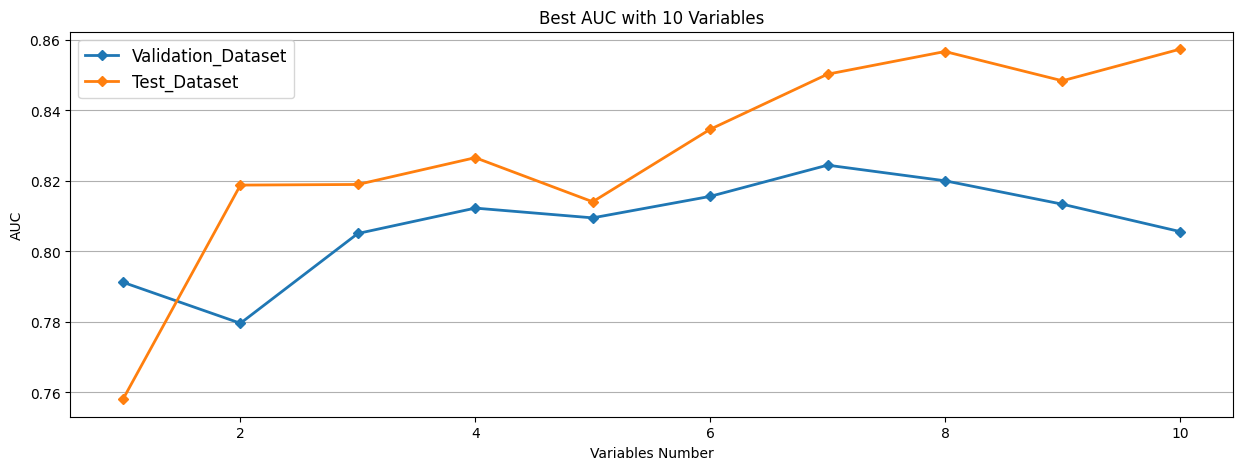

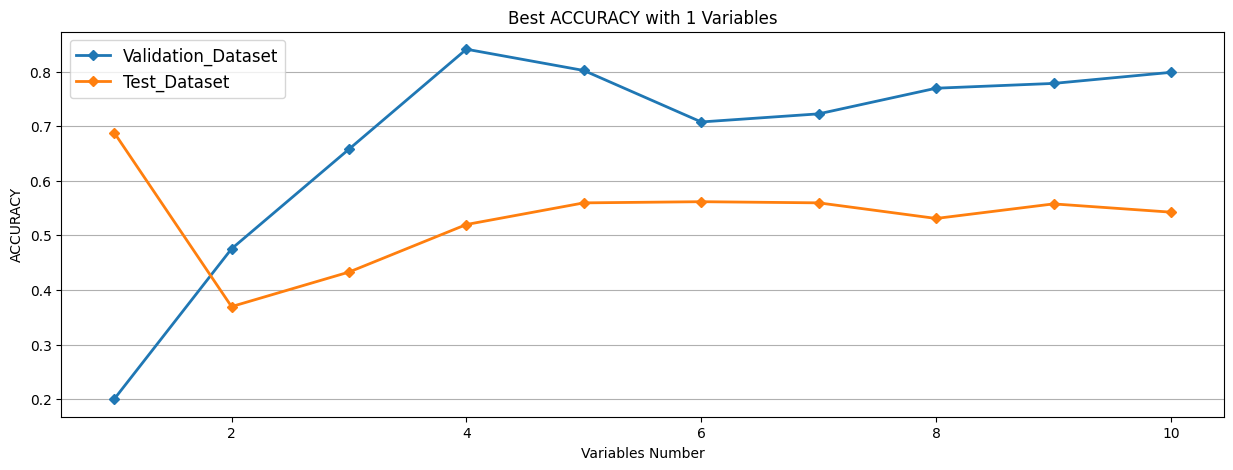

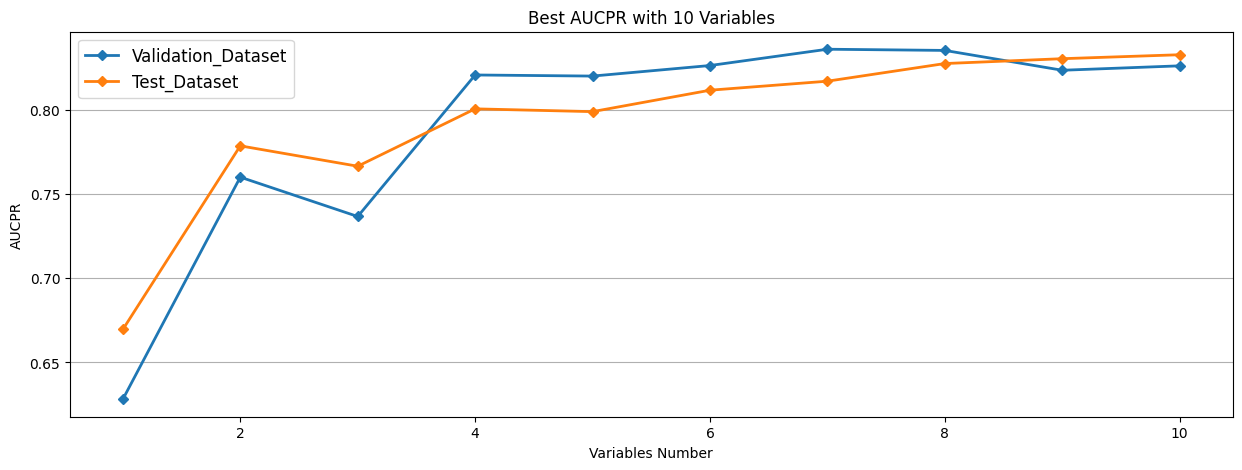

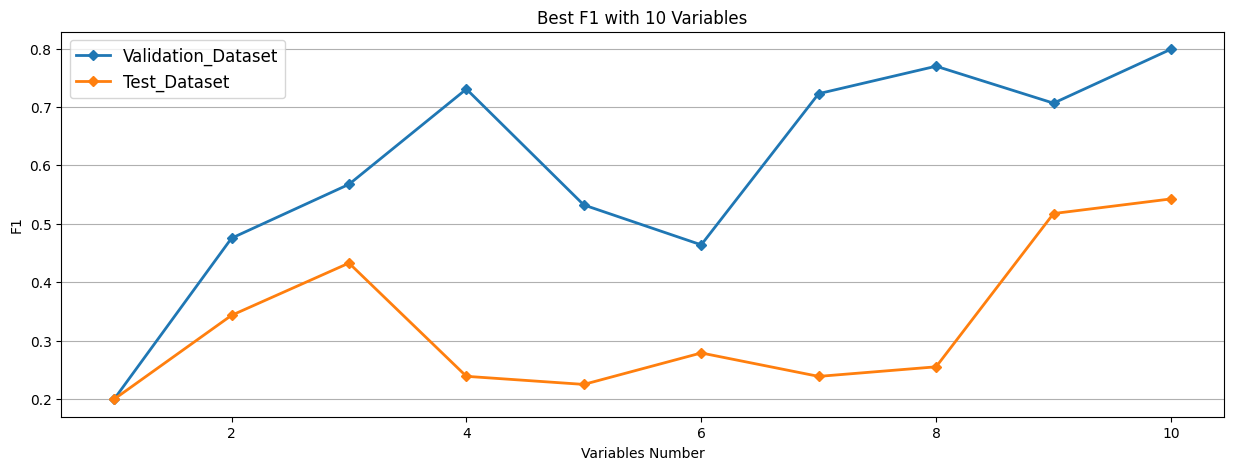

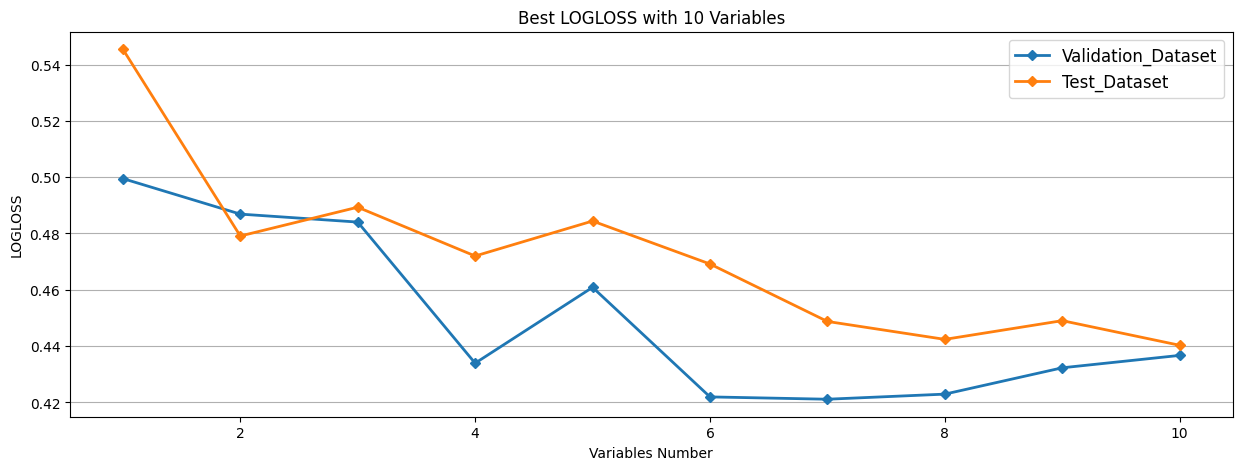

In [35]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [40]:
print('Consider using only the following variables: '+ str(df_features_sorted[0:int(max_oot_filtro)]))

Consider using only the following variables: ['nametitle', 'fare', 'age_mean', 'pclass', 'cabine_prefix', 'ticket_int', 'ticket_str', 'sibsp', 'embarked', 'parch']


# 5. Exporting the best model to Deploy

In [41]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: /home/sagemaker-user/FIEP-Modelos-de-Aprendizado-e-Arquiteturas-Cloud/output_model/models/best/GBM_3_AutoML_1_20220917_194024.zip


Detected 1 unused columns in the input data set: {}


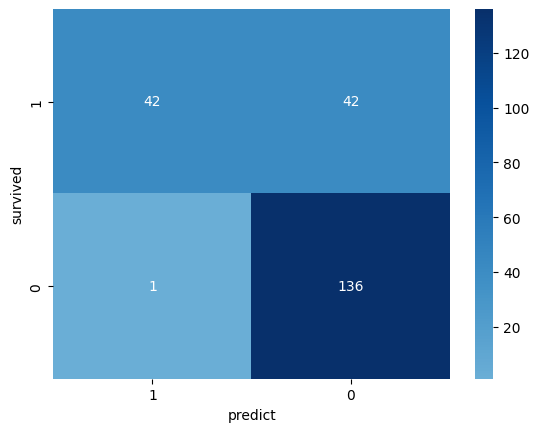

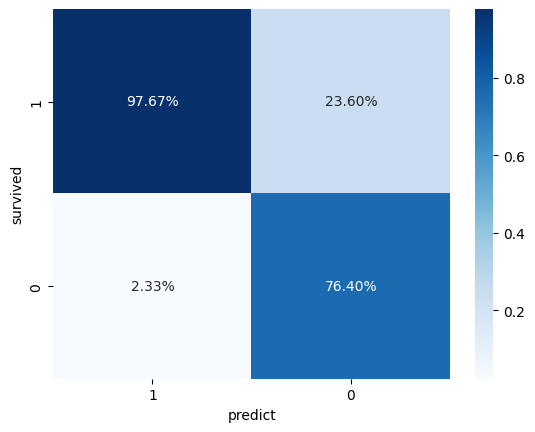

In [42]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

## 5.1 Cleaning Resources

In [43]:
# sm.delete_endpoint(EndpointName=ep_name)
# sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [46]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/train_data/train_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer

ClientError: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied

In [45]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

ClientError: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied

In [ ]:
csv_buffer = StringIO()
dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarTarget, VarId, VarDate])].to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/train_data/train_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer

csv_buffer = StringIO()
dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarTarget, VarId, VarDate])].to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/test_data/test_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer

In [69]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.delete_table(
        DatabaseName='auladeploymodelos',
        Name=ModelName+'_scored'
    )
except:
    print("table does not exist")

glue.update_crawler(Name='aula-deploy-modelos',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='aula-deploy-modelos')

table does not exist


{'ResponseMetadata': {'RequestId': '08be5629-aeb1-440c-b70e-8c3858ff2aab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 17 Sep 2022 20:17:05 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '08be5629-aeb1-440c-b70e-8c3858ff2aab'},
  'RetryAttempts': 0}}